In [2]:
import os
import sys

from scipy.signal import butter, lfilter, iirnotch, spectrogram
import numpy as np
import matplotlib.pyplot as plt

from degpy.session import Session

sess_paths = {
    'ps_17' : '/Volumes/Backup Plus/data/080602/080602_ps17_160704/2016-07-04_13-22-47',
    'ps_19' : '/Volumes/Backup Plus/data/080602/080602_ps19_160706/2016-07-06_13-38-43',
}

%matplotlib inline

## Getting session and terminal data 
The degpy module utilizes an overarching object for interfacing with the data called `Session`. Through this object, we can access metadata at the experiment level, as well as access data at the Terminal level via the `.get_terminal()` method. This method returns a `Terminal` object, which provides access to data collected from an individual tetrode.  

Through these objects, we can read in all of the raw channel data into a numpy array for downstream processing and model training.

In [3]:
# get session object
ps_17 = Session(sess_paths['ps_17'])

# Reading in all channels into a numpy array
X = []
for file in ps_17.data_files:
    if 'LFP' in file:
        X.append(ps_17.get_terminal(file).data)
        
X = np.array(X).T

# Loading in sample channel for exploration
lfp1 = ps_17.get_terminal('LFP1.ncs')

# compute session length (seconds)
sess_length = (lfp1.event_timestamps[-1] - lfp1.event_timestamps[0]) / 1e6

# get time data
time = np.linspace(0, sess_length, len(lfp1.data))

In the `Terminal` object exists a 1D array of all exposures, which is our target variable. However, the raw target is a sub-optimal format for training. The raw target contains labels such as `'b1s'`, which indicates a wooden block has been inserted into the Degu pen, while `'b1e'` indicates the block has been removed. Additionally, there are combinations of exposures, e.g. `'s0b1s` denotes another degu being added to the pen in addition to a wooden block. As such, this format does not lend itself to a simple one-hot matrix. 

To enable a representative target matrix, I created a custom method on the `Terminal` object that parses the labeling convention and converts it into a multi-hot target matrix to indicate which exposures are "on" or "off".

In [4]:
target_cols, target = lfp1.get_target_binary_matrix()

In [5]:
print('data size:\t{:.2f} MB'.format((X.itemsize*X.size) / 1e6))
print('target size:\t{:.2f} MB'.format(sys.getsizeof(target) / 1e6))

data size:	1426.10 MB
target size:	2139.14 MB


## Looking at raw broadband signal... 
To understand the raw data, we'll chart out the first 60s of data collection.

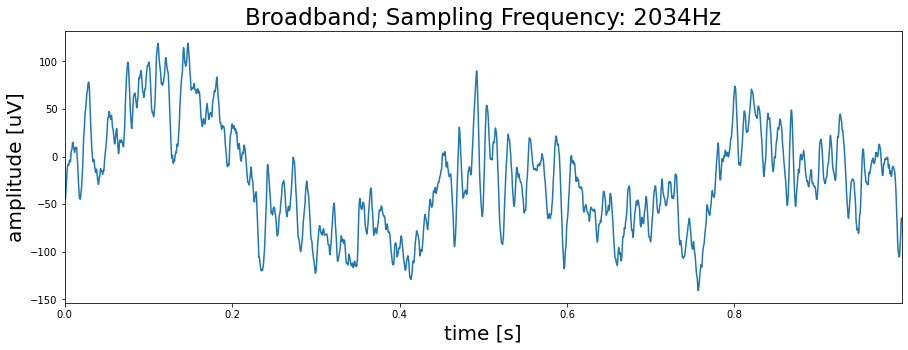

<Figure size 432x288 with 0 Axes>

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(time[0:lfp1.sampling_rate], lfp1.data[0:lfp1.sampling_rate])
ax.set_title('Broadband; Sampling Frequency: {}Hz'.format(lfp1.sampling_rate), fontsize=23)
ax.set_xlim(0, time[lfp1.sampling_rate])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)
plt.show()
plt.savefig('raw_signal_chart.png')

## Filtering Signal
Though there are many neuroscience papers that effectively use raw channel electrophysiology data for deep learning, the scope of this project is to analyze data subject to gamma band, which *may* indicate the degu is drawing recall of the exposure, if they remember seeing it before.

To effectively filter the data per our constraint, the `filter_data` function determines the nyquist frequency, derives the low and high bands, calculates the coefficients of the filter (in this case we are using a butterworth filter), we denotch the data at 60Hz to eliminate the electrical interference from US power outlets, and apply the filter to the matrix of channel data.

In [8]:
def filter_data(data, low, high, sf, order=2):
    # Determine Nyquist frequency
    nyq = sf/2

    # Set bands
    low = low/nyq
    high = high/nyq

    # Calculate coefficients
    b, a = butter(order, [low, high], btype='band')

    # Removing 60hz notch mains interference
    de_notch = iirnotch(60/nyq, 30)
    
    # Filter signal
    filtered_data = lfilter(de_notch[0], de_notch[1], lfilter(b, a, data))
    
    return filtered_data

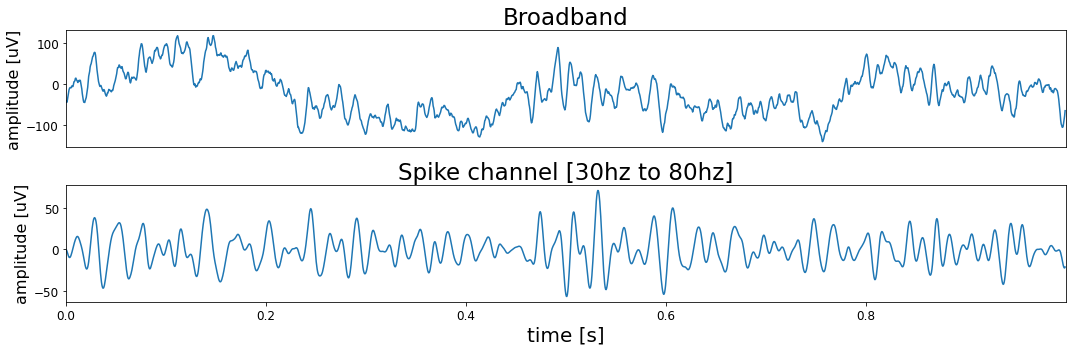

In [103]:
low_freq = 30
high_freq = 80
gamma_filter = filter_data(lfp1.data, low=low_freq, high=high_freq, sf=lfp1.sampling_rate)

# Plot signals
fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].plot(time[0:lfp1.sampling_rate], lfp1.data[0:lfp1.sampling_rate])
ax[0].set_xticks([])
ax[0].set_title('Broadband', fontsize=23)
ax[0].set_xlim(0, time[lfp1.sampling_rate])
ax[0].set_ylabel('amplitude [uV]', fontsize=16)
ax[0].tick_params(labelsize=12)

ax[1].plot(time[0:lfp1.sampling_rate], gamma_filter[0:lfp1.sampling_rate])
ax[1].set_title('Spike channel [{}hz to {}hz]'.format(low_freq, high_freq), fontsize=23)
ax[1].set_xlim(0, time[lfp1.sampling_rate])
ax[1].set_xlabel('time [s]', fontsize=20)
ax[1].set_ylabel('amplitude [uV]', fontsize=16)
ax[1].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('raw_signal_chart.png')
plt.show()

## Normalizing signal... 
We'll also normalize this training data, to better suit model training.

In [10]:
def normalize(data):
    return (data - np.mean(data)) / np.std(data)

gamma_filter_norm = normalize(gamma_filter)

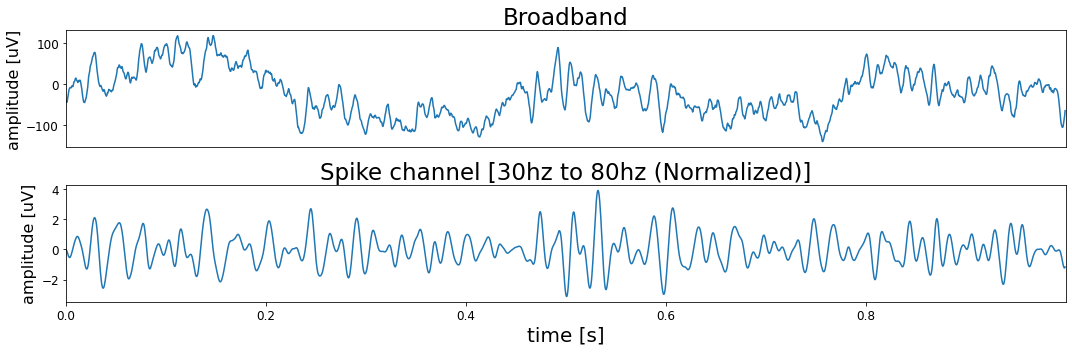

In [104]:
# Plot signals
fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].plot(time[0:lfp1.sampling_rate], lfp1.data[0:lfp1.sampling_rate])
ax[0].set_xticks([])
ax[0].set_title('Broadband', fontsize=23)
ax[0].set_xlim(0, time[lfp1.sampling_rate])
ax[0].set_ylabel('amplitude [uV]', fontsize=16)
ax[0].tick_params(labelsize=12)

ax[1].plot(time[0:lfp1.sampling_rate], gamma_filter_norm[0:lfp1.sampling_rate])
ax[1].set_title('Spike channel [{}hz to {}hz (Normalized)]'.format(low_freq, high_freq), fontsize=23)
ax[1].set_xlim(0, time[lfp1.sampling_rate])
ax[1].set_xlabel('time [s]', fontsize=20)
ax[1].set_ylabel('amplitude [uV]', fontsize=16)
ax[1].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('raw-and-filtered-signal-chart.png')
plt.show()

# Plotting Gamma Spectrogram 

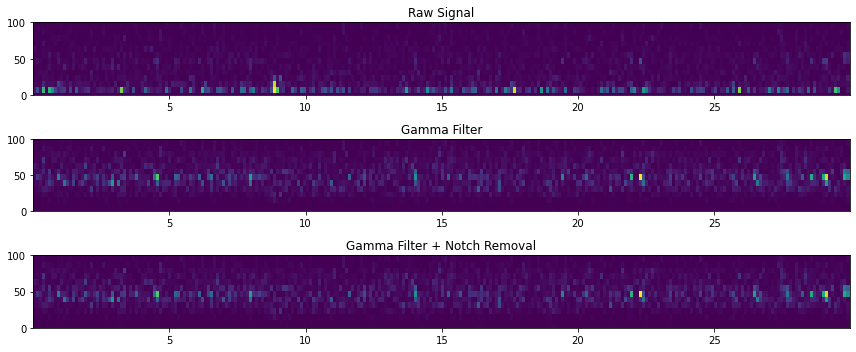

In [105]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5))

t_start = 500000
minutes = 30
cmap = 'viridis'

f, t, Sxx = spectrogram(lfp1.data[t_start:t_start+lfp1.sampling_rate*minutes], lfp1.sampling_rate)
axes[0].pcolormesh(t, f, Sxx, cmap=cmap,shading='auto')
axes[0].set_ylim(0, 100);
axes[0].set_title('Raw Signal')

f, t, Sxx = spectrogram(gamma_filter[t_start:t_start+lfp1.sampling_rate*minutes], lfp1.sampling_rate)
axes[1].pcolormesh(t, f, Sxx, cmap=cmap,shading='auto')
axes[1].set_ylim(0, 100);
axes[1].set_title('Gamma Filter')

f, t, Sxx = spectrogram(gamma_filter_norm[t_start:t_start+lfp1.sampling_rate*minutes], lfp1.sampling_rate)
axes[2].pcolormesh(t, f, Sxx, cmap=cmap,shading='auto')
axes[2].set_ylim(0, 100);
axes[2].set_title('Gamma Filter + Notch Removal')

plt.tight_layout()
plt.savefig('spectrogram.png')

## Split up Data 
We now have a filtered and normalized 2D matrix of tetrode signal data, as well as a 2D multi-hot target matrix. For downstream training, we'll convert our `X` matrix into a 3D matrix, and split up training and testing data.

In [15]:
from sklearn.model_selection import train_test_split

# Downsampling the data for memory sake
ds = 100
X_3d = X.reshape(X.shape[0], X.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(X_3d[::ds, :, :], target[::ds], test_size=0.25)

## Train Models
We'll first train an LSTM model without a CNN layer as a baseline for performance. Note that I will be performing training for only one 1 epoch. This will likely satisfy arriving at the optimal model parameters, given the size of the input data, memory space is a limiting factor on my machine.

In [16]:
import tensorflow as tf

from tensorflow.keras import layers, models

In [17]:
# Setting hyperparamters
epochs = 10
batch_size = 64

# Gathering dimensional data for LSTM input shape
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]

## Base LSTM RNN Model 

In [18]:
# Building base LSTM model architecture
model = models.Sequential()
model.add(layers.LSTM(100, input_shape=(n_timesteps, n_features)))
model.add(layers.Dropout(0.5)) # Adding dropout to regularize the model
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(n_outputs, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])

In [19]:
model.fit(X_train, y_train, epochs=epochs, batch_size=64)

Train on 111414 samples
Epoch 1/10
111414/111414 [==============================] - 93s 833us/sample - loss: 0.2289 - accuracy: 0.9290 - mse: 0.0616
Epoch 2/10
111414/111414 [==============================] - 83s 747us/sample - loss: 0.2153 - accuracy: 0.9326 - mse: 0.0583
Epoch 3/10
111414/111414 [==============================] - 83s 746us/sample - loss: 0.2118 - accuracy: 0.9333 - mse: 0.0575
Epoch 4/10
111414/111414 [==============================] - 82s 734us/sample - loss: 0.2104 - accuracy: 0.9336 - mse: 0.0572
Epoch 5/10
111414/111414 [==============================] - 80s 714us/sample - loss: 0.2090 - accuracy: 0.9338 - mse: 0.0569
Epoch 6/10
111414/111414 [==============================] - 107s 958us/sample - loss: 0.2082 - accuracy: 0.9339 - mse: 0.0567
Epoch 7/10
111414/111414 [==============================] - 181s 2ms/sample - loss: 0.2075 - accuracy: 0.9340 - mse: 0.0566
Epoch 8/10
111414/111414 [==============================] - 115s 1ms/sample - loss: 0.2066 - accuracy

In [20]:
lstm_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

37138/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [21]:
lstm_eval

[0.207110894949963, 0.9338262, 0.05664639]

## CNN-LSTM Hybrid Model 

Now that we've generated a baseline on the LSTM RNN model, I'll implement a hybrid CNN LSTM layer in place of the former LSTM layer. One consideration will be that this hybrid layer will require a 5d tensor input shape.This will require gathering the number of timesteps, features, and outputs, as well as the number of steps and the sequence length. From these dimensions we can reshape the data into the form (samples. time, channels, row, colsa).

In [23]:
n_steps = 3
n_length = 4

X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))

In [24]:
model = models.Sequential()
model.add(layers.ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(n_outputs, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Train on 111414 samples
Epoch 1/10
111414/111414 [==============================] - 40s 355us/sample - loss: 0.2356 - accuracy: 0.9281
Epoch 2/10
111414/111414 [==============================] - 43s 386us/sample - loss: 0.2293 - accuracy: 0.9297
Epoch 3/10
111414/111414 [==============================] - 44s 393us/sample - loss: 0.2264 - accuracy: 0.9305
Epoch 4/10
111414/111414 [==============================] - 43s 390us/sample - loss: 0.2225 - accuracy: 0.9312
Epoch 5/10
111414/111414 [==============================] - 44s 394us/sample - loss: 0.2186 - accuracy: 0.9323
Epoch 6/10
111414/111414 [==============================] - 44s 392us/sample - loss: 0.2149 - accuracy: 0.9329
Epoch 7/10
111414/111414 [==============================] - 44s 392us/sample - loss: 0.2130 - accuracy: 0.9334
Epoch 8/10
111414/111414 [==============================] - 44s 397us/sample - loss: 0.2118 - accuracy: 0.9336
Epoch 9/10
111414/111414 [==============================] - 42s 379us/sample - loss: 0.2

In [28]:
lstm_cnn_eval = model.evaluate(X_test, y_test, batch_size=64, verbose=0)

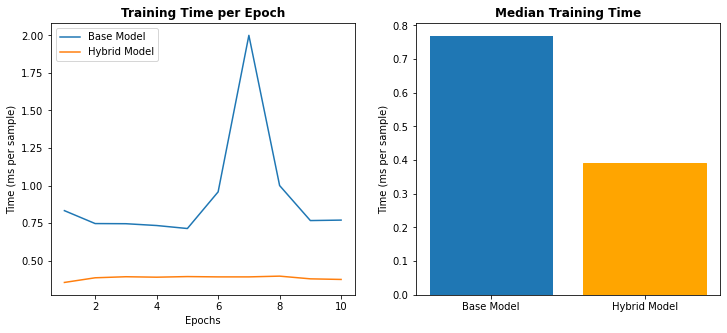

In [106]:
# Putting training time per sample into arrays for charting
# (These are copy pasted from the model training print statements, not doctored :P )
epochs_array = [i for i in range(1, 11)]
lstm_cnn_time_per_sample = [.355,.386,.393,.390,.394,.392,.392,.397,.379,.375]
lstm_time_per_sample = [.833,.747,.746,.734,.714,.958,2,1,.767,.770]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(epochs_array, lstm_time_per_sample, label='Base Model')
ax1.plot(epochs_array, lstm_cnn_time_per_sample, label='Hybrid Model')
ax1.set_ylabel('Time (ms per sample)')
ax1.set_xlabel('Epochs')
ax1.set_title('Training Time per Epoch', size=12, weight='bold')
ax1.legend()

barlist = ax2.bar([1, 2], 
        [np.median(lstm_time_per_sample), np.median(lstm_cnn_time_per_sample)],)

barlist[1].set_color('orange')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Base Model', 'Hybrid Model'])
ax2.set_ylabel('Time (ms per sample)')
ax2.set_title('Median Training Time', size=12, weight='bold')
plt.savefig('train-time.png');

In [100]:
[np.median(lstm_time_per_sample), np.median(lstm_cnn_time_per_sample)]

[0.7685, 0.391]

In [84]:
# Putting accuracy data into arrays for charting
# (These are copy pasted from the model training print statements, not doctored :P )
lstm_cnn_acc = [0.9281,0.9297,0.9305,0.9312,0.9323,0.9329,0.9334,0.9336,0.9335,0.9335]
lstm_acc = [0.9290,0.9326,0.9333,0.9336,0.9338,0.9339,0.9340,0.9341,0.9341,0.9343]

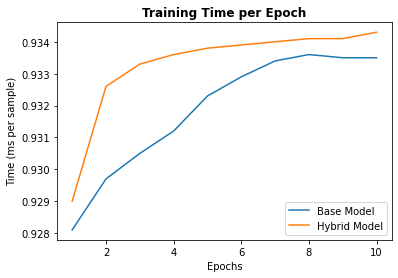

In [107]:
fig, ax1 = plt.subplots()
ax1.plot(epochs_array, lstm_cnn_acc, label='Base Model')
ax1.plot(epochs_array, lstm_acc, label='Hybrid Model')
ax1.set_ylabel('Time (ms per sample)')
ax1.set_xlabel('Epochs')
ax1.set_title('Training Time per Epoch', size=12, weight='bold')
ax1.legend()
plt.savefig('accuracy.png');

While accuracy of the CNN-LSTM hybrid model appears to see minimal improvement over the base LSTM model, the former trains significantly faster! The convolutions performed effectively extracts features to speed up the LSTM layer. 

In [98]:
mean_train_time_ratio = np.sum(lstm_cnn_time_per_sample) / np.sum(lstm_time_per_sample)

In [102]:
print("Mean Training Time Improvement: {:.2f}".format(1- mean_train_time_ratio))

Mean Training Time Improvement: 0.58
